# Introduction

In this notebook, the estimates for the energy consumption of the top 100 mineable cryptocurrencies is calculated. 
In the first section, a hardware based estimation is made. Secondly, a revenue based is made. 
After this, we take a look at the electronic waste by mining. Finally, we investigate the results and check for inter-and extrapollation.

In [1]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from ipywidgets import *
from datetime import datetime

In [2]:
DATA_PATH = 'data/'
HIST_PATH = DATA_PATH + 'hist/'
HARDWARE_PATH = DATA_PATH+'hardware/'

In [3]:
# Clean market cap and price
def clean_int(string):
    return float(string.strip('$').replace(',',''))

def clean_mineable_data(data):
    data = data.set_index('Name')
    data['market_cap'] = data['market_cap'].apply(lambda x:clean_int(x))    
    data['price'] = data['price'].apply(lambda x:clean_int(x))
    return data

In [4]:
# Read in data
dates = []
data_hist = []
for file in os.listdir(HIST_PATH):
    # Load the daily data in a list
    data_day = pd.read_csv(HIST_PATH+file)
    data_day = clean_mineable_data(data_day)
    data_hist.append(data_day)

    # Get the dates in a list
    date = datetime.strptime(file[13:23], '%m-%d-%Y')
    dates.append(date)

In [5]:
mineable_100 = pd.read_csv(HIST_PATH+'mineable_100_04-24-2020.csv')
mineable_100 = clean_mineable_data(mineable_100)
found_data = mineable_100[~mineable_100.isnull().any(axis=1)].copy()

## Parameters

In [6]:
seconds_in_year = 31536000
hours_in_year = 8760
kWh_to_J = 3600*10**3
W_to_TWh = hours_in_year/(10**12)

std_PUE = {'lower': 1, 'estimate': 1.1, 'upper':1.2}
revenue_percent = 0.60

## Geography 

### Coinshares

In [7]:
# https://www.china-briefing.com/news/china-electricity-prices-industrial-consumers/
# Sichian probably goes lower in wet season -> https://news.8btc.com/price-war-start-against-mining-operators-in-sichuan-as-supply-far-exceeds-demand
# America: https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/
data = {'location': ['Sichuan', 'China', 'Non-China', 'Other'],
        'share': [0.54,0.11,0.31,0.04],
        'normal_price': [0.074, 0.084, 0.061, 0.084], # World average for non-china
        'min_price': [0.035, 0.084, 0.061, 0.084], # American price for non-china
        'renewable': [0,0,0,0]}

In [8]:
geography = pd.DataFrame(data)
avg_electricity_price = np.sum(geography.share*geography.normal_price)/kWh_to_J # in $/J
min_electricity_price = np.sum(geography.share*geography.min_price)/kWh_to_J

In [9]:
avg_electricity_price

1.985277777777778e-08

In [10]:
#print(geography.set_index('location', drop=True).to_latex())

# Hardware based estimation

In this section we make a first estimation based on the most efficient hardware (found online)

## Historical

In [11]:
# Bitcoin forks have the same initial difficulty
bitcoin_forks = ['bitcoin', 'bitcoincash','bitcoinsv', 'litecoincash']

In [12]:
def hardware_based_estimation(data, PUE_dict = std_PUE, moving_avg_difficulty = 7, moving_avg_price=7, growth_factor=1, estimates=False, PUE_fix = False):
    """
    Function that calculates upper bound, lower bound, estimate and market cap for all data.
    Returns a list, each entry is the bounds for one day
    """
    bounds = []
    difficulties = pd.DataFrame()
    prices = pd.DataFrame()
    for i in range(len(data)):
        data_day = data[i]
        result = pd.DataFrame()
        found_data = data_day[~data_day.isnull().any(axis=1)].copy()
        
        # Fill in original difficulties
        found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
        found_missing_difficulty = found_data[found_data['difficulty_factor']!=0].copy()

        # Calculate moving avg of difficulty
        difficulties[i] = found_missing_difficulty['difficulty']
        found_missing_difficulty['difficulty_MA'] = difficulties[range(max(i-moving_avg_difficulty+1,0),i+1)].mean(axis=1)
    
        # Calculate moving avg of price
        prices[i] = found_missing_difficulty['price']*growth_factor
        found_missing_difficulty['price_MA'] = prices[range(max(i-moving_avg_price+1,0),i+1)].mean(axis=1)

        # Calculate nethash
        found_missing_difficulty['nethash_calc'] = found_missing_difficulty['difficulty_MA']*found_missing_difficulty['difficulty_factor']/found_missing_difficulty['block_time'] # amount of hashes per second

        # Create dictionairy that maps coins to their profitable hardware
        lower_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, PUE_dict,"lower",PUE_fix), axis = 1))
        upper_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, PUE_dict,"upper",PUE_fix), axis = 1))
        estimate_prof_hardware = dict(found_missing_difficulty.apply(lambda x: create_profitable_set(x, PUE_dict,"estimate",PUE_fix), axis = 1))
                
        # Calculate estimates
        result['lower_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x, lower_prof_hardware, True),axis=1)
        result['upper_bound'] = found_missing_difficulty.apply(lambda x: calc_bound(x, upper_prof_hardware, False),axis=1)
        result['estimate'] = found_missing_difficulty.apply(lambda x: calc_estimate(x, estimate_prof_hardware),axis=1)
        result['market_cap'] = found_missing_difficulty['market_cap']
        
        if estimates:
            result['estimate_weighted'] = found_missing_difficulty.apply(lambda x: calc_estimate_weighted(x, estimate_prof_hardware),axis=1)
            result['estimate_breakeven'] = found_missing_difficulty.apply(lambda x: calc_estimate_breakeven(x, estimate_prof_hardware),axis=1)
             
        result = result[result['estimate'] != 0]
        
        bounds.append(result.copy())
    
    return bounds

In [13]:
# Functions to go from the nBits to the first hashrate
def hex_to_bits(hex_number):
    if int(hex_number,16) >= 8:
        return 0
    elif int(hex_number,16) >= 4:
        return 1
    elif int(hex_number,16) >= 2:
        return 2
    elif int(hex_number,16) == 1:
        return 3
    else:
        return 4
        
def nBits_to_factor(nBits):
    if nBits[:2] != "0x":
        raise Exception("Wrong format, provide hexadecimal number")
    exp = 8*(int(nBits[:4],16)-3)
    mantisse = nBits[4:]
    i=0
    extra_0 = 0
    while hex_to_bits(mantisse[i]) == 4:
        extra_0 += 4
        i += 1
    extra_0 += hex_to_bits(mantisse[i])
    return 256-exp-4*len(mantisse)+extra_0

In [14]:
def difficulty_factor(coin):
    """
    Enter the difficulty factors used to calculate current hashrate. 
    These values where all found by exploring the first block, documentation or source code. 
    References are kept in separate excell sheet
    """
    if coin.name in bitcoin_forks:
        return 2**32
    if coin.name == 'zcash':
        return 2**13
    if coin.name == 'litecoin' or coin.name == 'monacoin':
        return 2**32
    if coin.name == 'ethereum' or coin.name == 'ethereumclassic':
        return 1
    if coin.name == 'monero':
        return 1 # https://github.com/monero-project/monero/blob/36241552b56b156c08319935baf7afda12deb3c5/src/cryptonote_basic/difficulty.h
    if coin.name == 'dash' or coin.name == 'dogecoin':
        return 2**20
    if coin.name == 'ravencoin':
        return 2**24
    if coin.name == 'horizen':
        return 2**nBits_to_factor("0x1f07ffff")
    if coin.name == 'komodo':
        return 2**nBits_to_factor("0x200f0f0f")
    else:
        return 0

## Hardware profitability threshold

Here we make our estimation more accurate by investigating entire hardware datasets (created in hardware.ipynb).

In [15]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
ethash_hardware = pd.read_csv(HARDWARE_PATH+'ethash_hardware_clean.csv',index_col=0)
equihash_hardware = pd.read_csv(HARDWARE_PATH+'equihash_hardware_clean.csv',index_col=0)
scrypt_hardware = pd.read_csv(HARDWARE_PATH+'scrypt_hardware_clean.csv',index_col=0)

# Create dict of algorithms with their hardware
algorithm_hardware = {'SHA-256':SHA256_hardware,'Ethash':ethash_hardware, 'Equihash':equihash_hardware, 'Scrypt':scrypt_hardware}

In [16]:
def calc_profitability_threshold(coin, PUE=1, elec_price = avg_electricity_price):
    if 'price_MA' in coin:
        reward_per_sec = coin['price_MA']*coin['block_reward']/coin['block_time']
    else:
        reward_per_sec = coin['price']*coin['block_reward']/coin['block_time']
    rev = reward_per_sec/coin['nethash_calc'] #$/h
    cost = elec_price
    return rev/(cost*PUE)

def is_profitable(coin, hardware, PUE=1, elec_price = avg_electricity_price):
    profitability_threshold = calc_profitability_threshold(coin, PUE, elec_price)
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False

In [17]:
def create_profitable_set(coin, PUE_dict, bound, PUE_fix):
    if coin.algorithm in algorithm_hardware:
        hardware = algorithm_hardware[coin.algorithm]
        if bound == "lower":
            prof_hardware = hardware[hardware.apply(lambda x: is_profitable(coin,x, PUE_dict['lower']),axis=1)]
        elif bound == "UPPER":
            prof_hardware = hardware[hardware.apply(lambda x: is_profitable(coin,x, PUE_dict['upper'], min_electricity_price),axis=1)]
        else:
            prof_hardware = hardware[hardware.apply(lambda x: is_profitable(coin,x, PUE_dict['estimate']),axis=1)]
        if prof_hardware.empty and PUE_fix:
            prof_hardware = hardware[hardware.consumption == hardware.consumption.min()]
        return prof_hardware
    return pd.DataFrame()

## Results

### bounds

In [18]:
def calc_bound(coin, coin_prof_hardware_dict, lower):
    """
    Returns a lower or upper bound on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name not in coin_prof_hardware_dict:
        #print(f"Error, no hardware for {coin.name}")
        return 0
    if coin_prof_hardware_dict[coin.name].empty:
        #print(f"Error, no profitable hardware for {coin.name}")
        return 0
    hardware = coin_prof_hardware_dict[coin.name].sort_values(by='consumption', ascending=lower).iloc[0]
    electricity_consumption = hardware['consumption']*coin['nethash_calc']
    return electricity_consumption

### Estimate

In [19]:
def calc_estimate(coin, coin_prof_hardware_dict):
    """
    Returns an on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name not in coin_prof_hardware_dict:
        #print(f"Error, no hardware for {coin.name}")
        return 0
    if coin_prof_hardware_dict[coin.name].empty:
        #print(f"Error, no profitable hardware for {coin.name}")
        return 0
    prof_hardware = coin_prof_hardware_dict[coin.name]
    num_prof_hardware = prof_hardware.shape[0]
    hashrate_part = coin['nethash_calc']/num_prof_hardware
    
    electricity_consumption = prof_hardware['consumption']*hashrate_part
    
    return np.sum(electricity_consumption)  

## Manual investigation

In [21]:
# All profitable hardware
bitcoin_profitable = set()
ethereum_profitable = set()
for data_day in data_hist:
    found_data = data_day[~data_day.isnull().any(axis=1)].copy()
    # Fill in original difficulties
    found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
    found_missing_difficulty = found_data[found_data['difficulty_factor']!=0].copy()
    # Calculate nethash
    found_missing_difficulty['nethash_calc'] = found_missing_difficulty['difficulty']*found_missing_difficulty['difficulty_factor']/found_missing_difficulty['block_time'] # amount of hashes per second
    
    prof_hardware_bitcoin = create_profitable_set(found_missing_difficulty.loc['bitcoin'], std_PUE, 'estimate', False)
    prof_hardware_ethereum = create_profitable_set(found_missing_difficulty.loc['ethereum'], std_PUE, 'estimate', False)
    
    bitcoin_profitable = bitcoin_profitable | set(prof_hardware_bitcoin['name'])
    ethereum_profitable = ethereum_profitable | set(prof_hardware_ethereum['name'])

In [22]:
pd.DataFrame(list(bitcoin_profitable), columns=['name']).to_csv('bitcoin_prof_hardware.csv', encoding='utf-16')
pd.DataFrame(list(ethereum_profitable), columns=['name']).to_csv('ethereum_prof_hardware.csv', encoding='utf-16')

# Revenue based estimation

Here we calculate an upper bound and estimate, assuming all revenues are used to cover the electricity costs
Upper bound: use minimum electricity cost (wet-season)
Estimate: use avg electricity cost

In [23]:
def revenue_based_estimation(data):
    """ 
    Returns the electricity use (in Watts) if 100% of revenues are used for electricity costs
    """
    bounds = []
    for data_daily in data:
        revenue_data = data_daily[['#', 'market_cap', 'price', 'block_time', 'block_reward']]
        revenue_data = revenue_data[~revenue_data.isnull().any(axis=1)].copy()
        revenue_data['revenue_per_sec'] = revenue_data['price']*revenue_data['block_reward']/revenue_data['block_time']

        revenue_data['estimate'] = revenue_data['revenue_per_sec']/avg_electricity_price 
        revenue_data['upper_bound'] = revenue_data['revenue_per_sec']/min_electricity_price 
        
        bounds.append(revenue_data[['estimate','upper_bound', 'market_cap']])
        
    return bounds

# Electronic waste 

Assume only ASIC's contribute to waste

- If only ASIC: all waste
- If ASIC&GPU: upper-bound: all ASIC, estimate: evenly distributed

waste = pd.DataFrame(columns=['coin','upper bound', 'estimate']).set_index('coin',drop=True)
for coin, hardware in coin_prof_hardware_dict.items():
    hardware_waste = hardware.copy()
    if hardware.empty:
        waste.loc[coin] = [0, 0]
        continue
    num_asic = np.sum(hardware['type']=='ASIC')
    num_hardware = hardware.shape[0]
    
    # Upper bound, all ASIC
    partial_hashrate = result.loc[coin,'estimate']/num_asic
    hardware_waste['qty_upper'] = hardware_waste.apply(lambda x: partial_hashrate/x['hashing_power'] if x.type == 'ASIC' else 0, axis = 1)
        
    # Estimate, evenly distributed
    partial_hashrate = result.loc[coin,'estimate']/num_hardware
    hardware_waste['qty_estimate'] = hardware_waste.apply(lambda x: partial_hashrate/x['hashing_power'] if x.type == 'ASIC' else 0, axis=1)
    
    waste.loc[coin] = [np.sum(hardware_waste['qty_upper']), np.sum(hardware_waste['qty_estimate'])]
waste

In [24]:
# Weight in kg
def hardware_weight(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 4.56
    if coin['algorithm'] == 'Scrypt':
        return 2.5
    if coin['algorithm'] == 'Ethash':
        return 10.5
    if coin['algorithm'] == 'Equihash':
        return 5.500
    return 0

In [25]:
#elec_waste = found_data[['#', 'tag', 'algorithm', 'num_hardware']].copy()
#elec_waste['weight_hardware'] = elec_waste.apply(lambda x: hardware_weight(x), axis=1)

In [26]:
#elec_waste['waste'] = elec_waste['weight_hardware']*elec_waste['num_hardware']/1.5
#elec_waste

# Results

In [27]:
def calc_hardware_bounds(bounds, PUE_dict = std_PUE):
    """
    Adds the PUE and sums over all coins
    """
    hardware_bounds = {'upper': [], 'lower': [], 'estimate': [], 'market_cap': []}    
    for bounds_day in bounds:
        lower_bound = np.sum(bounds_day['lower_bound'])*PUE_dict['lower']
        estimate = np.sum(bounds_day['estimate'])*PUE_dict['estimate']
        upper_bound = np.sum(bounds_day['upper_bound'])*PUE_dict['upper']
        market_cap = np.sum(bounds_day['market_cap'])
        
        hardware_bounds['lower'].append(lower_bound)
        hardware_bounds['estimate'].append(estimate)
        hardware_bounds['upper'].append(upper_bound)
        hardware_bounds['market_cap'].append(market_cap)

    return hardware_bounds

In [28]:
def calc_revenue_bounds(bounds, revenue_percent = 0.60):
    revenue_bounds = {'upper': [], 'lower': [], 'estimate': [], 'market_cap': []}    
    for bounds_day in bounds:
        
        upper_bound = np.sum(bounds_day['upper_bound'])
        estimate = np.sum(bounds_day['estimate'])
        market_cap = np.sum(bounds_day['market_cap'])
        
        revenue_bounds['upper'].append(upper_bound)
        revenue_bounds['estimate'].append(estimate*revenue_percent)
        revenue_bounds['market_cap'].append(market_cap)
    
    return revenue_bounds

In [37]:
# Get hardware bounds
hardware_bounds_coin = hardware_based_estimation(data_hist, PUE_fix=True)
hardware_bounds_total = calc_hardware_bounds(hardware_bounds_coin)

In [38]:
# Get revenue bounds
revenue_bounds_coin = revenue_based_estimation(data_hist)
revenue_bounds_total = calc_revenue_bounds(revenue_bounds_coin, revenue_percent)

In [39]:
# Get market cap of the used data
hardware_market_cap_hist = pd.Series(hardware_bounds_total['market_cap'])
# Get total market cap of data
total_market_cap_hist = pd.Series(revenue_bounds_total['market_cap'])

In [40]:
# Average bounds and market cap over dates per coin
coin_hardware_date = {'lower_bound': pd.DataFrame(), 'upper_bound': pd.DataFrame(), 'estimate': pd.DataFrame(), 'market_cap': pd.DataFrame()}

for i, data_day in enumerate(hardware_bounds_coin):
    coin_hardware_date['lower_bound'][i] = data_day['lower_bound']
    coin_hardware_date['upper_bound'][i] = data_day['upper_bound']
    coin_hardware_date['estimate'][i] = data_day['estimate']
    coin_hardware_date['market_cap'][i] = data_day['market_cap']

coin_hardware_avg = {}

for bound, data in coin_hardware_date.items():
    coin_hardware_avg[bound] = data.mean(axis=1)  

## Hardware based

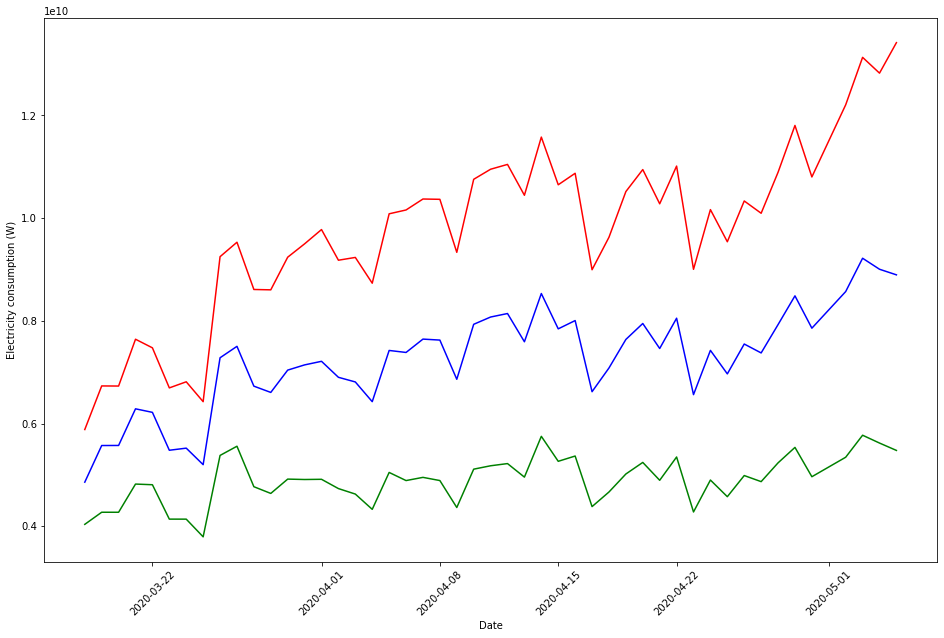

In [41]:
# Get hardware bounds
#hardware_bounds_coin = hardware_based_estimation(data_hist)
#hardware_bounds_total = calc_hardware_bounds(hardware_bounds_coin)
plt.figure(figsize=(16,10))
plt.plot(dates, hardware_bounds_total['lower'], color='green')
plt.plot(dates, hardware_bounds_total['estimate'], color='blue')
plt.plot(dates, hardware_bounds_total['upper'], color='red')
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.show()

In [42]:
coin_hardware_date['estimate'].columns = dates

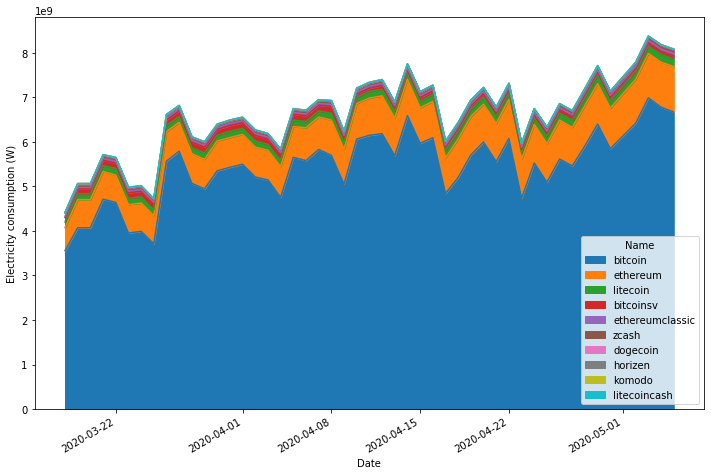

In [43]:
coin_hardware_date['estimate'].transpose().plot.area(figsize=(12,8))
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.show()

In [44]:
coin_hardware_date['estimate'].index

Index(['bitcoin', 'ethereum', 'litecoin', 'bitcoinsv', 'ethereumclassic',
       'zcash', 'dogecoin', 'horizen', 'komodo', 'litecoincash'],
      dtype='object', name='Name')

In [ ]:
bitcoin_contributions = coin_hardware_date['estimate'].loc['bitcoin']/np.sum(coin_hardware_date['estimate'])
print(f"The contribution of bitcoin to the total is minimum {np.min(bitcoin_contributions)}, maximum {np.max(bitcoin_contributions)}\
and on average {np.mean(bitcoin_contributions)}%")

ethereum_contributions = coin_hardware_date['estimate'].loc['ethereum']/np.sum(coin_hardware_date['estimate'])
print(f"The contribution of ethereum to the total is minimum {np.min(ethereum_contributions)}, maximum {np.max(ethereum_contributions)}\
and on average {np.mean(ethereum_contributions)}%")

bit_eth_contributions = bitcoin_contributions+ethereum_contributions
print(f"The contribution of ethereum and bitcoin to the total is minimum {np.min(bit_eth_contributions)}, maximum {np.max(bit_eth_contributions)}\
and on average {np.mean(bit_eth_contributions)}%")

## Revenue based

In [ ]:
plt.plot(dates, revenue_bounds_total['upper'])
plt.plot(dates, revenue_bounds_total['estimate'])
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.show()

## Extrapolation

### Market share

First calculate what part of top100 mineable and of total market cap we capture with our data

In [ ]:
hardware_data_market = hardware_market_cap_hist/total_market_cap_hist
print(f'The hardware based estimation represents minimum {round(hardware_data_market.min(),3)*100}%, maximum {round(hardware_data_market.max(),4)*100}%\n\
 and on average {round(hardware_data_market.mean(),3)*100}% of the market cap of the mineable top 100')

In [ ]:
# Data of 21/04/2020
mineable_market_cap_hist = pd.read_csv(DATA_PATH+'mineable_all.csv')
mineable_market_cap_hist = mineable_market_cap_hist['market_cap'].apply(clean_int)
mineable_market_cap_sum = mineable_market_cap_hist.sum()
hardware_mineable_share = hardware_market_cap_hist[34]/mineable_market_cap_sum
print(f'This is {round(hardware_mineable_share,4)*100}% of the total mineable market cap on 21/04/2020')

In [ ]:
top100_share = total_market_cap_hist[len(total_market_cap_hist)-1]/mineable_market_cap_sum
print(f'The top 100 captures {round(top100_share,3)*100}% of the total mineable market')

This means that, if our hypothesis is correct, we can divide our result bij 0.95 to get the total energy consumption of the mineable market

In [ ]:
# Get total market cap from https://p.nomics.com/cryptocurrency-bitcoin-api
url = "https://api.nomics.com/v1/market-cap/history?key=demo-26240835858194712a4f8cc0dc635c7a&start=2020-03-18T00%3A00%3A00Z"
total_market_cap_hist = pd.DataFrame(json.loads(urllib.request.urlopen(url).read()))['market_cap'].astype(float)
hardware_data_share_total = hardware_market_cap_hist/total_market_cap_hist

print(f'This is minimum {round(hardware_data_share_total.min(),4)*100}%, maximum {round(hardware_data_share_total.max(),4)*100}%\
 and on average {round(hardware_data_share_total.mean(),3)*100}% of the total market cap')

### Hypothesis testing

In [ ]:
market_cap_mean = coin_hardware_avg['market_cap']
energy_consumption_mean = coin_hardware_avg['estimate']

In [ ]:
found_data_energy = pd.concat([energy_consumption_mean,market_cap_mean],axis=1, keys=["energy_consumption", "market_cap"])
# Drop 0 values
found_data_energy = found_data_energy[found_data_energy['energy_consumption'] != 0]

In [ ]:
plt.figure(figsize=(12,9))

found_data_energy['energy_consumption'].plot(kind='bar')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('Annual energy consumption (in W)')
plt.xlabel('Coin')
plt.title('Annual electricity consumption of different cryptocurrencies')
plt.show()

In [ ]:
plt.figure(figsize=(14,10))

plt.scatter(found_data_energy['market_cap'],found_data_energy['energy_consumption'])
z = np.polyfit(found_data_energy['market_cap'],found_data_energy['energy_consumption'], 1)
p = np.poly1d(z)
x = found_data_energy['market_cap']
y = z[0]*x+z[1]
plt.plot(found_data_energy['market_cap'],p(found_data_energy['market_cap']),"r--")
#plt.plot(x,y, "b--")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Market cap ($)')
plt.ylabel('Annual energy consumption (W)')
plt.xticks(rotation=45)
plt.title('Annual energy consumption vs market cap of cryptocurrencies')
plt.show()

In [ ]:
z

In [ ]:
x = found_data_energy['market_cap']
y = z[0]*x+z[1]
plt.plot(x,y,"r--")

## Combining all results

- Hardware based
- Revenue based
- BECI
- CBECI

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(dates, hardware_bounds_total['estimate'], label="Hardware estimate", color="blue")
plt.plot(dates, hardware_bounds_total['lower'], label="Hardware lower bound",color="green")
plt.plot(dates, hardware_bounds_total['upper'], label="Hardware upper bound", color="red")
plt.plot(dates, revenue_bounds_total['upper'], label="Revenue upper bound", color="#FA9883")
plt.plot(dates, revenue_bounds_total['estimate'], label="Revenue estimate", color="lightblue")
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.legend()
plt.savefig('results.png')
plt.show()

### Mean consumption

In [ ]:
print(np.mean(hardware_bounds_total['lower'])*W_to_TWh)
print(np.mean(hardware_bounds_total['estimate'])*W_to_TWh)
print(np.mean(hardware_bounds_total['upper'])*W_to_TWh)

### Compare to bitcoin values

In [ ]:
bitcoin_price = [data.loc['bitcoin','price'] for data in data_hist]
bitcoin_difficulty = [data.loc['bitcoin', 'difficulty'] for data in data_hist]

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax1.plot(dates, hardware_bounds_total['estimate'], label="Hardware estimate", color="blue")
ax1.plot(dates, hardware_bounds_total['lower'], label="Hardware lower bound",color="green")
ax1.plot(dates, hardware_bounds_total['upper'], label="Hardware upper bound", color="red")
ax1.plot(dates, revenue_bounds_total['upper'], label="Revenue upper bound", color="#FA9883")
ax1.plot(dates, revenue_bounds_total['estimate'], label="Revenue estimate", color="lightblue")
plt.xticks(rotation=45)
ax1.set_ylabel("Electricity consumption (W)")
ax1.set_xlabel("Date")
ax1.legend()


ax2 = ax1.twinx()
ax2.plot(dates, bitcoin_price, label="bitcoin_price", color="orange")
ax2.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax1.plot(dates, hardware_bounds_total['estimate'], label="Hardware estimate", color="blue")
ax1.plot(dates, hardware_bounds_total['lower'], label="Hardware lower bound",color="green")
ax1.plot(dates, hardware_bounds_total['upper'], label="Hardware upper bound", color="red")
ax1.plot(dates, revenue_bounds_total['upper'], label="Revenue upper bound", color="#FA9883")
ax1.plot(dates, revenue_bounds_total['estimate'], label="Revenue estimate", color="lightblue")
plt.xticks(rotation=45)
ax1.set_ylabel("Electricity consumption (W)")
ax1.set_xlabel("Date")
ax1.legend()


ax2 = ax1.twinx()
ax2.plot(dates, bitcoin_difficulty, label="bitcoin_difficulty", color="orange")
ax2.legend()
plt.show()

# Parameters

## Growth factor

In [ ]:
# Get hardware bounds
for i in np.linspace(1,4, num=7):
    hardware_bounds_coin_growth = hardware_based_estimation(data_hist, growth_factor=i)
    hardware_bounds_total_growth = calc_hardware_bounds(hardware_bounds_coin_growth)
    #plt.plot(dates, hardware_bounds_total_growth['lower'])
    plt.plot(dates, hardware_bounds_total_growth['estimate'], label=i)
    #plt.plot(dates, hardware_bounds_total_growth['upper'])
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.legend()
plt.show()

## PUE

In [ ]:
results = {}

for estimate_PUE in [1, 1.05, 1.1, 1.15, 1.20, 1.50]:
    PUE = {'lower':1,'estimate':estimate_PUE,'upper':1.20}
    hardware_PUE_coin = hardware_based_estimation(data_hist, PUE_dict = PUE,PUE_fix=True)
    hardware_PUE_total = calc_hardware_bounds(hardware_PUE_coin)
    results[estimate_PUE] = hardware_PUE_total['estimate']
    plt.plot(dates, hardware_PUE_total['estimate'], label=estimate_PUE)

plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.legend()
plt.show()

## Electricity cost (geography)

## Different estimate scenario's

In [ ]:
def calc_estimations(bounds, PUE = 1.1):
    """
    Adds the PUE and sums over all coins
    """
    estimates = {'uniform': [], 'weighted': [], 'breakeven': []}    
    for bounds_day in bounds:
        uniform = np.sum(bounds_day['estimate'])*PUE
        weighted = np.sum(bounds_day['estimate_weighted'])*PUE
        breakeven = np.sum(bounds_day['estimate_breakeven'])*PUE

        estimates['uniform'].append(uniform)
        estimates['weighted'].append(weighted)
        estimates['breakeven'].append(breakeven)
    return estimates

### Weighted

In [ ]:
def calc_estimate_weighted(coin, coin_prof_hardware_dict):
    """
    Returns an on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name not in coin_prof_hardware_dict:
        #print(f"Error, no hardware for {coin.name}")
        return 0
    if coin_prof_hardware_dict[coin.name].empty:
        #print(f"Error, no profitable hardware for {coin.name}")
        return 0
    prof_hardware = coin_prof_hardware_dict[coin.name].copy()
    
    total_efficiency = np.sum(prof_hardware['efficiency'])
    efficiency_share = prof_hardware['efficiency']/total_efficiency
    
    prof_hardware['hashrate_part'] = (coin['nethash_calc']*efficiency_share)
    
    electricity_consumption = prof_hardware['consumption']*prof_hardware['hashrate_part']
    
    return np.sum(electricity_consumption)  

### Break-even period

In [ ]:
bitcoin_hardware_cost = pd.read_csv(HARDWARE_PATH + 'bitcoin_hardware_cost.csv')
ethereum_hardware_cost = pd.read_csv(HARDWARE_PATH + 'ethereum_hardware_cost.csv')
hardware_cost_dict = {'bitcoin':bitcoin_hardware_cost, 'ethereum': ethereum_hardware_cost}

In [ ]:
def calc_breakeven_share(breakeven_data):
    breakeven_rev = 1 / breakeven_data
    total_breakeven = np.sum(breakeven_rev)
    return breakeven_rev/total_breakeven

In [ ]:
# TODO: implement this code in profitability threshold
def calc_estimate_breakeven(coin, coin_prof_hardware_dict, PUE=std_PUE):
    """
    Returns an on the electricity consumption of cryptocoins in W
    To put Wh per year, multiply by hours_in_year
    """
    if coin.name != "bitcoin" and coin.name != "ethereum":
        return calc_estimate(coin, coin_prof_hardware_dict)
        
    prof_hardware = coin_prof_hardware_dict[coin.name].copy()
    prof_hardware = pd.merge(hardware_cost_dict[coin.name], prof_hardware, on='name', how='inner')
    
    revenue_per_sec = coin['price_MA']*coin['block_reward']/coin['block_time']
    
    # breakeven time (s) is investment cost / (rev-costs) 
    
    prof_hardware['revenue'] = (prof_hardware['hashing_power']/coin['nethash_calc'])*revenue_per_sec
    prof_hardware['cost'] = prof_hardware['power']*avg_electricity_price*PUE['estimate']
    
    prof_hardware['breakeven'] = prof_hardware['price']/(prof_hardware['revenue']-prof_hardware['cost'])
        
    prof_hardware['breakeven_share'] = calc_breakeven_share(prof_hardware['breakeven'])
        
    prof_hardware['hashrate_part'] = (coin['nethash_calc']*prof_hardware['breakeven_share'])
    
    electricity_consumption = prof_hardware['consumption']*prof_hardware['hashrate_part']
    
    return np.sum(electricity_consumption)  

In [ ]:
# Get hardware bounds
hardware_estimates = hardware_based_estimation(data_hist, estimates=True)
hardware_estimates_total = calc_estimations(hardware_estimates)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(dates, hardware_estimates_total['weighted'], label="weighted")
plt.plot(dates, hardware_estimates_total['uniform'], label="uniform")
plt.plot(dates, hardware_estimates_total['breakeven'], label="breakeven")
plt.plot(dates, hardware_bounds_total['lower'], label="lower")
plt.plot(dates, hardware_bounds_total['upper'], label="upper")
plt.xticks(rotation=45)
plt.ylabel("Electricity consumption (W)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [ ]:
weighted_difference_perc = (np.array(hardware_estimates_total['uniform'])-np.array(hardware_estimates_total['weighted']))/np.array(hardware_estimates_total['uniform'])
breakeven_difference_perc = (np.array(hardware_estimates_total['breakeven'])-np.array(hardware_estimates_total['weighted']))/np.array(hardware_estimates_total['uniform'])

In [ ]:
def estimations_differences(hardware_estimates_total, method):
    difference_perc = (np.array(hardware_estimates_total['uniform'])-np.array(hardware_estimates_total[method]))/np.array(hardware_estimates_total['uniform'])
    minimum = round(np.min(difference_perc),3)*100
    maximum = round(np.max(difference_perc),3)*100
    mean = round(np.mean(difference_perc),3)*100
    print(f" Minimum: {minimum} \n Maximum: {maximum} \n Mean: {mean}")

In [ ]:
estimations_differences(hardware_estimates_total, 'weighted')
estimations_differences(hardware_estimates_total, 'breakeven')

# Old

## First web-based trial (OLD)

First, we calculate a lower bound by using only the most efficient hardware

In [ ]:
def hardware_hashrate(coin): # Max hashes per second for the hardware
    if coin['algorithm'] == 'SHA-256':
        return 16*10**12
    if coin['algorithm'] == 'Scrypt':
        return 504*10**6
    if coin['algorithm'] == 'Ethash':
        return 190*10**6
    if coin['algorithm'] == 'Equihash':
        return 42*10**3
    return 0

In [ ]:
# Energy use in Watts
def hardware_consumption(coin): 
    if coin['algorithm'] == 'SHA-256':
        return 1280
    if coin['algorithm'] == 'Scrypt':
        return 970
    if coin['algorithm'] == 'Ethash':
        return 800
    if coin['algorithm'] == 'Equihash':
        return 760
    return 0

In [ ]:
def hardware_consumption_hash(coin): # Joule per hash
    if coin['algorithm'] == 'SHA-256':
        return 0.1/(10**9)
    if coin['algorithm'] == 'Scrypt':
        return 1.6/(10**6) # Antminer L3+ https://www.asicminervalue.com/miners/bitmain/antminer-l3-504mh
    if coin['algorithm'] == 'Ethash':
        return 4/(10**6) # Bitmain Antminer E3 – Ethereum 190 MH/S
    else: 
        return 0

In [ ]:
def calc_num_hardware(coin):
    if coin['hardware_hashrate'] == 0:
        return 0
    if coin['nethash_calc'] != 0:
        return coin['nethash_calc']/coin['hardware_hashrate'] 
    else:
        return coin['nethash_scraped']/coin['hardware_hashrate']

In [ ]:
found_data['difficulty_factor'] = found_data.apply(lambda x: difficulty_factor(x), axis=1)
found_data['hardware_hashrate'] = found_data.apply(lambda x: hardware_hashrate(x), axis=1)
found_data['hardware_consumption'] = found_data.apply(lambda x: hardware_consumption(x), axis=1)

In [ ]:
found_data['nethash_calc'] = found_data['difficulty']*found_data['difficulty_factor']/found_data['block_time'] # amount of hashes per second
found_data['num_hardware'] = found_data.apply(lambda x: calc_num_hardware(x),axis=1)
found_data['energy_per_second'] = found_data['num_hardware']*found_data['hardware_consumption'] # in Watt
found_data['annual_energy'] = found_data['energy_per_second']*8760 # hours in a year
found_data

In [ ]:
found_data_difficulty = found_data[found_data['difficulty_factor'] != 0]
print(found_data_difficulty[["#", "algorithm", "difficulty_factor"]].to_latex())

In [ ]:
total_energy_crypto = np.sum(found_data['annual_energy'])
total_energy_crypto_TWh = total_energy_crypto/10**12
total_energy_crypto_TWh

In [ ]:
total_energy_world_TWh = 19504 # TWh 

In [ ]:
total_energy_crypto_TWh/total_energy_world_TWh

0.4% of global electricity

## Extrapollation of energy use of other crypto coins

What percent of crypto market cap is represented in the dataset?

In [ ]:
found_market_cap = found_data['market_cap'].sum()
top100_market_cap = mineable_100['market_cap'].sum()
total_market_cap =  186318558825 #https://coinmarketcap.com/charts/
print(f'The webscrabed data represents {round(found_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_market_cap/total_market_cap,3)*100}% of the total market cap')

In [ ]:
found_data_energy = result[result['estimate'] != 0]
found_manual_market_cap = result['market_cap'].sum()
print(f'The manual data represents {round(found_manual_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_manual_market_cap/total_market_cap,3)*100}% of the total market cap')

Looking up all the other initial difficulties (~15 more coins) would only gain us an additional 0.4% of the total market cap

In [ ]:
result['estimate'].plot(kind='bar')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('annual energy consumption (in Wh)')
plt.xlabel('coin')
plt.title('Annual energy consumption of different cryptocurrencies')
plt.show()

In [ ]:
plt.scatter(result['market_cap'],result['estimate'])
plt.yscale('log')
plt.ylabel('annual energy consumption (Wh)')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Annual energy consumption vs market cap of cryptocurrencies')
plt.show()

Linear correlation between market cap and energy consumption with some outliers (e.g. Dogecoin, which uses auxilary POW with litecoin

In [ ]:
nethash_calc = result[result['estimate'] != 0].sort_values(by='algorithm')

In [ ]:
cdict= {'Equihash':'blue', 'Ethash':'grey','Lyra2REv2':'green','RandomX':'black','SHA-256':'red','Scrypt':'orange','X11':'lightgreen','X16Rv2':'purple'}
cmap = nethash_calc['algorithm'].apply(lambda x: cdict[x])
plt.scatter(nethash_calc['market_cap'],nethash_calc['estimate'],c=cmap,label=nethash_calc['algorithm'])
plt.yscale('log')
plt.ylabel('nethash calculated')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Nethash calculated vs market cap of cryptocurrencies')
plt.show()

## Results function

dates = []
hardware_bounds = {'upper': [], 'lower': [], 'estimate': [], 'market_cap': []}
revenue_bounds = {'upper': [], 'estimate': []}

# Used to check hypothesis and extrapollation
market_cap_hardware = pd.DataFrame()
coin_energy = pd.DataFrame()
market_caps_total = []

for file in os.listdir(HIST_PATH):
    data = pd.read_csv(HIST_PATH+file)
    data = clean_mineable_data(data)

    # Get the dates in a list
    date = datetime.strptime(file[13:23], '%m-%d-%Y')
    dates.append(date)
    
    # Get hardware bounds
    bounds = hardware_based_estimation(data)
    # Add bound per coin per day
    coin_energy[date] = bounds['estimate']*ESTIMATE_PUE
    
    # Get bounds for all coins
    hardware_bounds = calc_hardware_bounds(bounds, hardware_bounds)
    
    # Get market cap of the used data
    market_cap_hardware[date] = bounds['market_cap']
        
    # Get revenue bounds
    revenue_bounds = calc_revenue_bounds(data,revenue_bounds)
    
    # Get total market cap of data
    market_caps_total.append(np.sum(data['market_cap']))

## Extrapolation

In [ ]:
found_data_energy = found_data[found_data['annual_energy'] != 0]
found_manual_market_cap = found_missing_difficulty['market_cap'].sum()
print(f'The manual data represents {round(found_manual_market_cap/top100_market_cap,3)*100}% of the market cap of the top 100, and {round(found_manual_market_cap/total_market_cap,3)*100}% of the total market cap')

Looking up all the other initial difficulties (~15 more coins) would only gain us an additional 0.4% of the total market cap

In [ ]:
# Which ranks of the market cap are represented?
found_data[found_data['difficulty_factor'] != 0]['#'].hist(bins=10)
plt.show()

In [ ]:
found_data_energy['annual_energy'].plot(kind='bar')
plt.yscale('log')
plt.xticks(rotation=45)
plt.ylabel('annual energy consumption (in Wh)')
plt.xlabel('coin')
plt.title('Annual energy consumption of different cryptocurrencies')
plt.show()

In [ ]:
plt.scatter(found_data_energy['market_cap'],found_data_energy['annual_energy'])
plt.yscale('log')
plt.ylabel('annual energy consumption (Wh)')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Annual energy consumption vs market cap of cryptocurrencies')
plt.show()

Linear correlation between market cap and energy consumption with some outliers (e.g. Dogecoin, which uses auxilary POW with litecoin

In [ ]:
nethash_calc = found_data[found_data['nethash_calc'] != 0].sort_values(by='algorithm')

In [ ]:
cdict= {'Equihash':'blue', 'Ethash':'grey','Lyra2REv2':'green','RandomX':'black','SHA-256':'red','Scrypt':'orange','X11':'lightgreen','X16Rv2':'purple'}
cmap = nethash_calc['algorithm'].apply(lambda x: cdict[x])
plt.scatter(nethash_calc['market_cap'],nethash_calc['nethash_calc'],c=cmap,label=nethash_calc['algorithm'])
plt.yscale('log')
plt.ylabel('nethash calculated')
plt.xscale('log')
plt.xlabel('market cap ($)')
plt.xticks(rotation=45)
plt.title('Nethash calculated vs market cap of cryptocurrencies')
plt.show()